# **Import the required packages**

In [81]:
#For data reading and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib
#matplotlib.rcParams["figure.figsize"] = (20,10)

#For model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#For evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

#For model saving
import pickle as pkl
import json

#**Read and analyze data from csv file**

In [12]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/Bengaluru_House_Data.csv')
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [14]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


#**Checking NaN values**

In [15]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

#**Visualizing data**

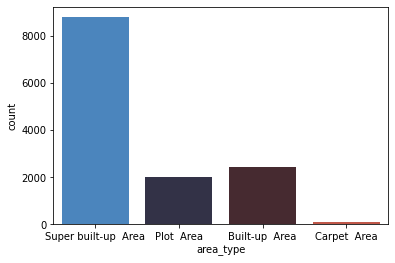

In [16]:
sns.countplot( x='area_type', data=df, palette="icefire");

<BarContainer object of 13320 artists>

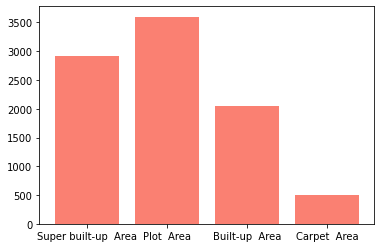

In [17]:
plt.bar(df.area_type,df.price,color=['salmon'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


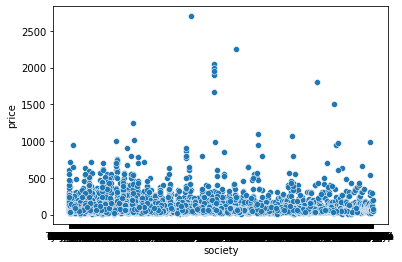

In [18]:
sns.scatterplot(df['society'],df['price'])

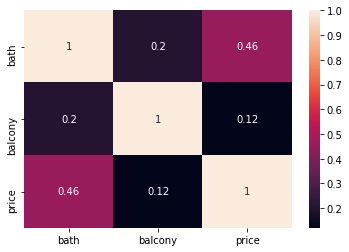

In [19]:
corr_mat=df.corr()
sns.heatmap(corr_mat,annot=True)

#**Dropping the columns which won't influence our model much**

In [20]:
df.shape


(13320, 9)

In [21]:
df=df.drop(['area_type','availability','society'],axis=1)
df

,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,0.0,231.00
13316,Richards Town,4 BHK,3600,5.0,NaN,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,1.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,1.0,488.00


In [22]:
df.isna().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [23]:
df=df.dropna()

In [24]:
df.isna().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [25]:
df.shape

(12710, 6)

In [26]:
df.head()

,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [27]:
df['BHK']= df['size'].apply(lambda x: int(x.split(' ')[0]))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,location,size,total_sqft,bath,balcony,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,1.0,51.00,2


In [28]:
df=df.drop('size',axis=1)

In [29]:
df.shape

(12710, 6)

In [30]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [31]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

#df['total_sqft']=df['total_sqft'].apply(is_float)

In [32]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,balcony,price,BHK
30,Yelahanka,2100 - 2850,4.0,0.0,186.000,4
122,Hebbal,3067 - 8156,4.0,0.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,0.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,0.0,43.490,2
188,KR Puram,1015 - 1540,2.0,0.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,0.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,0.0,63.770,2
661,Yelahanka,1120 - 1145,2.0,0.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,0.0,445.000,4
772,Banashankari Stage VI,1160 - 1195,2.0,0.0,59.935,2


In [33]:
def preprocess_sqft(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
        
        

df['total_sqft']=df['total_sqft'].apply(preprocess_sqft)

In [34]:
df.shape

(12710, 6)

In [35]:
df.total_sqft.head()


0    1056.0
1    2600.0
2    1440.0
3    1521.0
4    1200.0
Name: total_sqft, dtype: float64

In [36]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,balcony,price,BHK


In [37]:
df[~df.total_sqft.notnull()]

,location,total_sqft,bath,balcony,price,BHK
410,Kengeri,NaN,1.0,0.0,18.50,1
775,Basavanagara,NaN,2.0,1.0,93.00,1
1019,Marathi Layout,NaN,1.0,0.0,110.00,1
1086,Narasapura,NaN,2.0,2.0,29.50,2
1400,Chamrajpet,NaN,9.0,1.0,296.00,9
1712,Singena Agrahara,NaN,3.0,1.0,95.00,3
1743,Hosa Road,NaN,3.0,1.0,115.00,3
1821,Sarjapur,NaN,3.0,1.0,76.00,3
2881,Volagerekallahalli,NaN,2.0,2.0,38.00,2
3228,Dodda Banaswadi,NaN,5.0,1.0,140.00,5


In [38]:
df.total_sqft.isnull().sum() 

42

In [39]:
df=df.dropna()

In [40]:
df[~df.total_sqft.notnull()]

,location,total_sqft,bath,balcony,price,BHK


In [41]:
df.shape

(12668, 6)

In [42]:
df['price_per_sqft']=df['price']*100000/df['total_sqft']
df.head()

,location,total_sqft,bath,balcony,price,BHK,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


In [43]:
df.shape

(12668, 7)

In [44]:
df.location=df.location.apply(lambda x: x.strip())
loc_stats=df.location.value_counts(ascending=False)
loc_stats

Whitefield         514
Sarjapur  Road     372
Electronic City    302
Kanakpura Road     259
Thanisandra        233
                  ... 
Tharabanahalli       1
Kamdhenu Nagar       1
MM Layout            1
Mudalpalaya          1
SHANTHINAGAR         1
Name: location, Length: 1248, dtype: int64

In [45]:
len(loc_stats[loc_stats>10])

235

In [46]:
loc_stats_less_than_10=loc_stats[loc_stats>10]

In [47]:
df.location=df.location.apply(lambda x: 'other' if x in (loc_stats_less_than_10) else x)

In [48]:
df.location[df['location']!='other']

18           Ramakrishnappa Layout
19              Manayata Tech Park
25                 Mangammanapalya
42                     Ganga Nagar
49                Himagiri Meadows
                   ...            
13278    Reliaable Tranquil Layout
13285                 VHBCS Layout
13291               Weavers Colony
13292             Udayapur Village
13302         Annaiah Reddy Layout
Name: location, Length: 2741, dtype: object

In [49]:
df.location.unique()

array(['other', 'Ramakrishnappa Layout', 'Manayata Tech Park', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [50]:
df[df.total_sqft/df.BHK<300].head()

,location,total_sqft,bath,balcony,price,BHK,price_per_sqft
58,other,1407.0,4.0,1.0,150.0,6,10660.980810
68,other,1350.0,7.0,0.0,85.0,8,6296.296296
70,Double Road,500.0,3.0,2.0,100.0,3,20000.000000
78,other,460.0,1.0,0.0,22.0,2,4782.608696
89,other,710.0,6.0,3.0,160.0,6,22535.211268


In [51]:
df = df[~(df.total_sqft/df.BHK<300)]

In [52]:
df

,location,total_sqft,bath,balcony,price,BHK,price_per_sqft
0,other,1056.0,2.0,1.0,39.07,2,3699.810606
1,other,2600.0,5.0,3.0,120.00,4,4615.384615
2,other,1440.0,2.0,3.0,62.00,3,4305.555556
3,other,1521.0,3.0,1.0,95.00,3,6245.890861
4,other,1200.0,2.0,1.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13314,other,1715.0,3.0,3.0,112.00,3,6530.612245
13315,other,3453.0,4.0,0.0,231.00,5,6689.834926
13317,other,1141.0,2.0,1.0,60.00,2,5258.545136
13318,other,4689.0,4.0,1.0,488.00,4,10407.336319


In [53]:
df.shape

(12013, 7)

In [54]:
df.price_per_sqft.describe()

count     12013.000000
mean       6206.082347
std        3985.518807
min         267.829813
25%        4199.363057
50%        5252.525253
75%        6823.529412
max      176470.588235
Name: price_per_sqft, dtype: float64

In [55]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
    
df = remove_pps_outliers(df)
df.shape

(9761, 7)

In [56]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df = remove_bhk_outliers(df)
# df8 = df7.copy()
df.shape

(5549, 7)

Text(0, 0.5, 'Count')

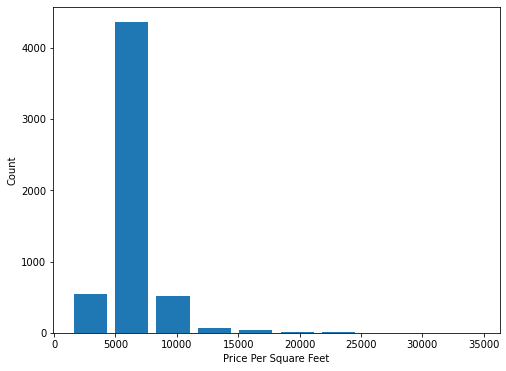

In [57]:


plt.subplots(figsize=(8,6))
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [58]:
df = df[df.bath<df.BHK+2]

In [59]:
df.shape

(5490, 7)

Text(0, 0.5, 'No. of houses')

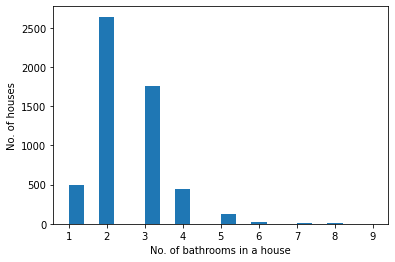

In [60]:
plt.hist(df.bath,bins=20)
plt.xlabel('No. of bathrooms in a house')
plt.ylabel('No. of houses')

#**Converting 'Object' values of Location into Numerical form using One Hot Encoding**

In [61]:
dummies = pd.get_dummies(df.location)
dummies

,1st Block BEL Layout,1st Block HBR Layout,1st Block HRBR Layout,1st Block Koramangala,1st Stage Indira Nagar,2nd Block Hrbr Layout,2nd Block Jayanagar,2nd Phase JP Nagar,2nd Stage Arekere Mico Layout,3rd Block Banashankari,3rd Block Hrbr Layout,3rd Block Jayanagar,3rd Block Koramangala,3rd Phase JP Nagar,4th Block Jayanagar,4th Block Koramangala,4th Phase JP Nagar,4th T block Jayanagar,5th Block Hbr Layout,6th block Koramangala,7th Block Jayanagar,8th Block Jayanagar,8th block Koramangala,9th Block Jayanagar,A Narayanapura,AGS Layout,AMS Layout,Abbaiah Reddy Layout,Agrahara Dasarahalli,Aishwarya Crystal Layout,Akshaya Vana,Akshayanagara East,Akshya Nagar,Alfa Garden Layout,Alur,Amarjyothi Colony,Ambedkar Colony,Amblipura,Amruthnagar,Anand Nagar,...,Upkar Layout,VGP Layout,Vadarpalya,Vaishnavi Layout,Vajarahalli,Varanasi,Varsova Layout,"Varthur Road,",Vasanth nagar,Vasantha Vallabha Nagar,Veer Sandra,Veersandra,Venkatadri Layout,Venkatapura,Venugopal Reddy Layout,Versova Layout,Vibuthipura,Victoria Layout,Vignana Nagar,Vijaya Bank Layout,Vijinapura,Vimanapura,Vinayak Nagar,Vinayaka Nagar,Virat Nagar,Virupakshapura,Vishwanatha Nagenahalli,Vishwapriya Nagar,Vittal Nagar,Vivek Nagar,Volagerekallahalli,"Whitefield,",Wilson Garden,Yarandahalli,Yemlur,frazertown,manyata park,other,south,tc.palya
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9758,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [62]:
df=pd.concat([df,dummies.drop('other',axis='columns')],axis='columns')

In [63]:
df.head()

,location,total_sqft,bath,balcony,price,BHK,price_per_sqft,1st Block BEL Layout,1st Block HBR Layout,1st Block HRBR Layout,1st Block Koramangala,1st Stage Indira Nagar,2nd Block Hrbr Layout,2nd Block Jayanagar,2nd Phase JP Nagar,2nd Stage Arekere Mico Layout,3rd Block Banashankari,3rd Block Hrbr Layout,3rd Block Jayanagar,3rd Block Koramangala,3rd Phase JP Nagar,4th Block Jayanagar,4th Block Koramangala,4th Phase JP Nagar,4th T block Jayanagar,5th Block Hbr Layout,6th block Koramangala,7th Block Jayanagar,8th Block Jayanagar,8th block Koramangala,9th Block Jayanagar,A Narayanapura,AGS Layout,AMS Layout,Abbaiah Reddy Layout,Agrahara Dasarahalli,Aishwarya Crystal Layout,Akshaya Vana,Akshayanagara East,Akshya Nagar,...,Upadhyaya Layout,Upkar Layout,VGP Layout,Vadarpalya,Vaishnavi Layout,Vajarahalli,Varanasi,Varsova Layout,"Varthur Road,",Vasanth nagar,Vasantha Vallabha Nagar,Veer Sandra,Veersandra,Venkatadri Layout,Venkatapura,Venugopal Reddy Layout,Versova Layout,Vibuthipura,Victoria Layout,Vignana Nagar,Vijaya Bank Layout,Vijinapura,Vimanapura,Vinayak Nagar,Vinayaka Nagar,Virat Nagar,Virupakshapura,Vishwanatha Nagenahalli,Vishwapriya Nagar,Vittal Nagar,Vivek Nagar,Volagerekallahalli,"Whitefield,",Wilson Garden,Yarandahalli,Yemlur,frazertown,manyata park,south,tc.palya
0,1st Block BEL Layout,1540.0,3.0,2.0,85.0,3,5519.480519,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block HBR Layout,600.0,1.0,0.0,45.0,1,7500.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block HBR Layout,3150.0,4.0,2.0,150.0,4,4761.904762,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block HRBR Layout,1250.0,2.0,1.0,67.0,2,5360.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Koramangala,1415.0,2.0,3.0,110.0,2,7773.851590,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df=df.drop('location',axis='columns')

In [65]:
df.shape

(5490, 511)

In [66]:
df.head()

,total_sqft,bath,balcony,price,BHK,price_per_sqft,1st Block BEL Layout,1st Block HBR Layout,1st Block HRBR Layout,1st Block Koramangala,1st Stage Indira Nagar,2nd Block Hrbr Layout,2nd Block Jayanagar,2nd Phase JP Nagar,2nd Stage Arekere Mico Layout,3rd Block Banashankari,3rd Block Hrbr Layout,3rd Block Jayanagar,3rd Block Koramangala,3rd Phase JP Nagar,4th Block Jayanagar,4th Block Koramangala,4th Phase JP Nagar,4th T block Jayanagar,5th Block Hbr Layout,6th block Koramangala,7th Block Jayanagar,8th Block Jayanagar,8th block Koramangala,9th Block Jayanagar,A Narayanapura,AGS Layout,AMS Layout,Abbaiah Reddy Layout,Agrahara Dasarahalli,Aishwarya Crystal Layout,Akshaya Vana,Akshayanagara East,Akshya Nagar,Alfa Garden Layout,...,Upadhyaya Layout,Upkar Layout,VGP Layout,Vadarpalya,Vaishnavi Layout,Vajarahalli,Varanasi,Varsova Layout,"Varthur Road,",Vasanth nagar,Vasantha Vallabha Nagar,Veer Sandra,Veersandra,Venkatadri Layout,Venkatapura,Venugopal Reddy Layout,Versova Layout,Vibuthipura,Victoria Layout,Vignana Nagar,Vijaya Bank Layout,Vijinapura,Vimanapura,Vinayak Nagar,Vinayaka Nagar,Virat Nagar,Virupakshapura,Vishwanatha Nagenahalli,Vishwapriya Nagar,Vittal Nagar,Vivek Nagar,Volagerekallahalli,"Whitefield,",Wilson Garden,Yarandahalli,Yemlur,frazertown,manyata park,south,tc.palya
0,1540.0,3.0,2.0,85.0,3,5519.480519,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,600.0,1.0,0.0,45.0,1,7500.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3150.0,4.0,2.0,150.0,4,4761.904762,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1250.0,2.0,1.0,67.0,2,5360.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1415.0,2.0,3.0,110.0,2,7773.851590,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
X=df.drop("price",axis=1)
Y=df.price

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [69]:
rf_clf=RandomForestRegressor()
rf_clf.fit(X_train,Y_train)
rf_Y_pred=rf_clf.predict(X_test)
rf_score=rf_clf.score(X_test,Y_test)
print(rf_score)

0.9896588073174887


In [70]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
np.mean(cross_val_score(rf_clf, X, Y, cv=cv))

0.9117817403436852

In [71]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(42)
for i in range(1,40,1):
  print(f"With {i*10} estimators:")
  clf2=RandomForestRegressor(n_estimators=i*10,max_depth=i,random_state=i).fit(X_train,Y_train)
  print(f"Accuracy: {clf2.score(X_test,Y_test)*100:2f}%")

With 10 estimators:
Accuracy: 32.344169%
With 20 estimators:
Accuracy: 69.908789%
With 30 estimators:
Accuracy: 81.114736%
With 40 estimators:
Accuracy: 89.418342%
With 50 estimators:
Accuracy: 95.869130%
With 60 estimators:
Accuracy: 96.123388%
With 70 estimators:
Accuracy: 98.394930%
With 80 estimators:
Accuracy: 98.586798%
With 90 estimators:
Accuracy: 96.906300%
With 100 estimators:
Accuracy: 94.333222%
With 110 estimators:
Accuracy: 98.894135%
With 120 estimators:
Accuracy: 97.961491%
With 130 estimators:
Accuracy: 97.425604%
With 140 estimators:
Accuracy: 97.948243%
With 150 estimators:
Accuracy: 98.830369%
With 160 estimators:
Accuracy: 95.893415%
With 170 estimators:
Accuracy: 98.588902%
With 180 estimators:
Accuracy: 97.541680%
With 190 estimators:
Accuracy: 98.021579%
With 200 estimators:
Accuracy: 98.678269%
With 210 estimators:
Accuracy: 98.528623%
With 220 estimators:
Accuracy: 98.731040%
With 230 estimators:
Accuracy: 98.793154%
With 240 estimators:
Accuracy: 98.444838%
W

In [72]:
RF_clf2=RandomForestRegressor(n_estimators=110,max_depth=11,random_state=11)
RF_clf2.fit(X_train,Y_train)
RF2_Y_pred=RF_clf2.predict(X_test)
RF2_score=RF_clf2.score(X_test,Y_test)
RF2_score

0.9889413485714135

In [73]:
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
np.mean(cross_val_score(RF_clf2, X, Y, cv=cv2))

0.9052610243016863

In [74]:
mean_squared_error(Y_test,RF2_Y_pred)

65.16124955147804

In [75]:
df1=pd.DataFrame({'Actual': Y_test,'Predicted': RF2_Y_pred })
df1.head()

,Actual,Predicted
8086,58.0,57.815527
34,240.0,240.178371
8,500.0,484.028571
6287,192.0,185.830531
8336,204.0,202.133702


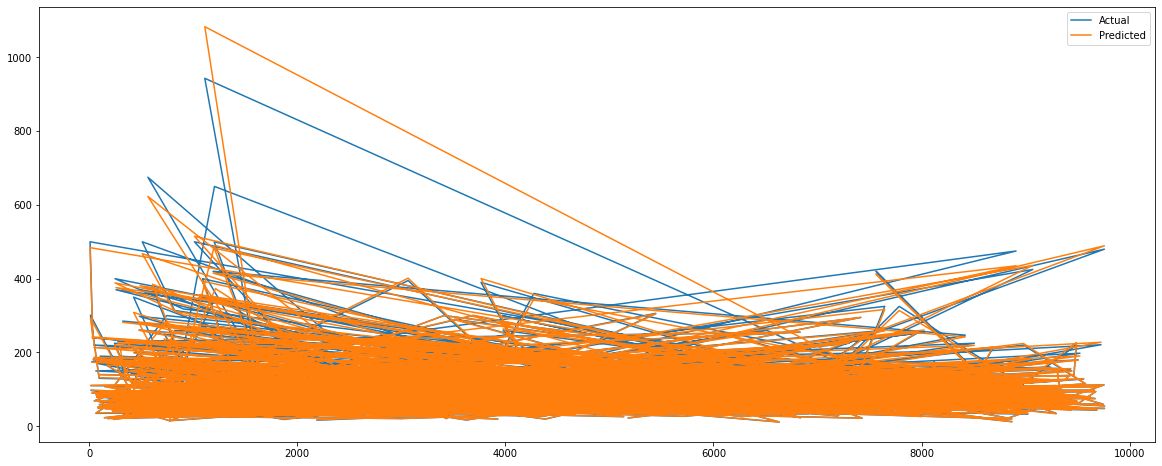

In [76]:
df1.plot(figsize=(20,8),kind='line')

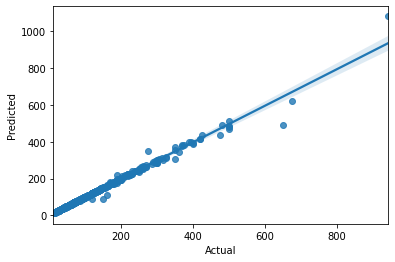

In [77]:
sns.regplot(x='Actual',y='Predicted',data=df1)

In [82]:
pkl.dump(RF_clf2,open("Bangalore-House-Price.pkl","wb"))

In [83]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))